In [1]:
####### Imports #######
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.feature import hog

import os

In [2]:
class Dict(dict):
    """Container object exposing keys as attributes.
    Dict objects are sometimes used as an output for functions and methods.
    They extend dictionaries by enabling values to be accessed by key,
    `bunch["value_key"]`, or by an attribute, `bunch.value_key`.
    Examples
    --------
    >>> from sklearn.utils import Bunch
    >>> b = Dict(a=1, b=2)
    >>> b['b']
    2
    >>> b.b
    2
    >>> b.a = 3
    >>> b['a']
    3
    >>> b.c = 6
    >>> b['c']
    6
    """

    def __init__(self, **kwargs):
        super().__init__(kwargs)

    def __setattr__(self, key, value):
        self[key] = value

    def __dir__(self):
        return self.keys()

    def __getattr__(self, key):
        try:
            return self[key]
        except KeyError:
            raise AttributeError(key)

    def __setstate__(self, state):
        # Bunch pickles generated with scikit-learn 0.16.* have an non
        # empty __dict__. This causes a surprising behaviour when
        # loading these pickles scikit-learn 0.17: reading bunch.key
        # uses __dict__ but assigning to bunch.key use __setattr__ and
        # only changes bunch['key']. More details can be found at:
        # https://github.com/scikit-learn/scikit-learn/issues/6196.
        # Overriding __setstate__ to be a noop has the effect of
        # ignoring the pickled __dict__
        pass

In [6]:
####### Code #######

def createDict(folder_path,size):
    """Create a DataFrame from a folder containing images
    
    Args:
        fodler_path (str): The folder location of the dataset

    Returns:
        df (DataFrame): The dataset in a pandas DataFrame format
    """
    datas = []
    targets = []
    
    for i in os.listdir(folder_path):
        for j in os.listdir(folder_path + "/" + i):
            datas.append(Image.open(folder_path + "/" + i + "/" + j).resize((size[0],size[1])))
            targets.append(i)
    return Dict(data = datas, target = targets)

['Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red', 'Apple Red'

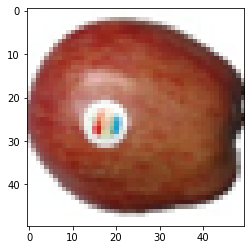

In [9]:
dico = createDict("/home/labourde/Bureau/projet-integrateur/fruits",(100,100))
print(dico.target)
plt.imshow(dico.data[0])